# **Chapter 4**

In [1]:
import numpy as np
import pandas as pd
import General

import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'png'

import arviz as az
import pymc as pm
import scipy.stats as stats

az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### **4M1**

For the model definition below, simulate observed $y$ values from the prior (not the posterior).<br>
$y_i ∼ \text{Normal}(\mu, \sigma)$<br>
$\mu ∼ \text{Normal}(0, 10)$<br>
$\sigma ∼ \text{Uniform}(1)$

In [2]:
mu = stats.norm.rvs(loc=0, scale=10, size=10000)
sigma = stats.uniform.rvs(loc=1, scale=10, size=10000)
y = [np.random.normal(mu, sigma, 1) for mu, sigma in zip(mu, sigma)]

### **4M2**

 Translate the model just above into a quap formula.

In [3]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)  # Prior for mu
    sigma = pm.Uniform("sigma", lower=0, upper=1)  # Prior for sigma
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=np.concatenate(y))  # Observed y values

    # Fit the model using MAP (similar to quap)
    posterior = pm.find_MAP()

print("Posterior estimates:")
print(f'mu: {posterior['mu']:.2f}')
print(f'sigma: {posterior['sigma']:.2f}')

Output()

Posterior estimates:
mu: 0.15
sigma: 1.00


### **4M4**

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose.

$h_i ∼ \text{Normal}(\mu, \sigma)$<br>
$\mu ∼ \alpha + \beta (y_i)$<br>
$\alpha ∼ \text{Normal}(0, 100)$<br>
$\beta ∼ \text{Normal}(0, 10)$<br>
$\sigma ∼ \text{Uniform}(50)$

### **4H1**

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| **Individual**  | **Weight** | **Expected Height** | **89% Interval**  |
|-----------------|------------|---------------------|-------------------|
| 1               | 46.95      | ?                   | ?                 |
| 2               | 43.72      | ?                   | ?                 |
| 3               | 64.78      | ?                   | ?                 |
| 4               | 32.59      | ?                   | ?                 |
| 5               | 54.63      | ?                   | ?                 |

In [4]:
howell1 = pd.read_csv(r'.\..\Data\Howell1.csv', delimiter=';')
data = howell1[howell1['age'] >= 18]

In [6]:
with pm.Model() as model:
    sigma = pm.Uniform('sigma', 0, 50)
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, tau=1)
    mu = alpha + beta*data['weight'].values
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=data['height'].values)

    # Posterior Distribution
    posterior = pm.find_MAP()
    # Hessian Matrix
    Hess = pm.find_hessian(posterior, vars=[alpha, beta, sigma])
    # Extract Samples
    trace = pm.sample(draws=1000, step=pm.Metropolis(), tune=500, progressbar=False)
    
print("\nPosterior estimates:")
print(f'sigma: {posterior['sigma']:.2f}')
print(f'alpha: {posterior['alpha']:.2f}')
print(f'beta: {posterior['beta']:.2f}')

Output()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Posterior estimates:
alpha: 114.53
beta: 0.89
sigma: 5.07


In [90]:
# The inverse of the Hessian matrix is often used to estimate the covariance matrix of the parameters.
# The diagonal elements of the covariance matrix correspond to the variances of the parameters, and the off-diagonal elements correspond to the covariances.
var_cov = np.linalg.inv(Hess)
means = np.fromiter([posterior['alpha'], posterior['beta'], posterior['sigma']], dtype=float)
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)

# Credibility Interval
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x)) for x in np.linspace(20, 70, 100)]
)

# Interval for Real Data
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x)
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in np.linspace(20, 70, 100)]
)

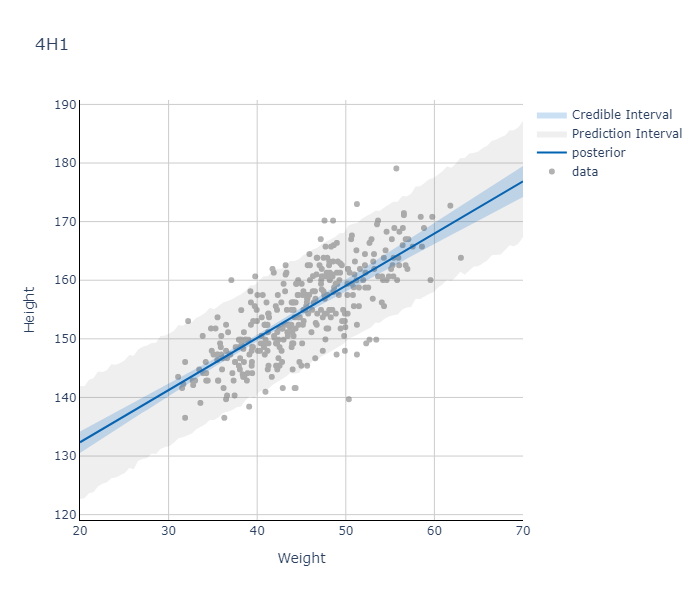

In [103]:
x = np.linspace(20, 70, 100)

fig = go.Figure()

fig.add_trace(trace=go.Scatter(
    x=data['weight'].values, y=data['height'].values,
    mode='markers', marker=dict(color='grey'), opacity=0.6,
    name='data'
))

mu = posterior["alpha"] + posterior["beta"] * (x)
fig.add_trace(trace=go.Scatter(
    x=x, y=mu,
    mode='lines', line=dict(color='#0064b2'),
    name='posterior'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(100, 100, 100, 0.1)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Prediction Interval'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(0, 100, 200, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Credible Interval'
))

General.main_layout(fig, title='4H1', x='Weight', y='Height')
fig.show()

In [111]:
# define the data
individuals = np.linspace(1, 5, 5)
weight = np.array([46.95, 43.72, 64.78, 32.59, 54.63])
# compute the mean predictions
means = posterior["alpha"] + posterior["beta"] * weight
# compute the prediction intervals
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in weight]
)
data_dict = {
    "Individual": individuals,
    "Weight": weight,
    "Expected height": means,
    "Lower 89% interval": pred_intervals[:, 0],
    "Upper 89% interval": pred_intervals[:, 1],
}
display(pd.DataFrame(data=data_dict))

,Individual,Weight,Expected height,Lower 89% interval,Upper 89% interval
0,1.0,46.95,156.354090,147.034336,166.118587
1,2.0,43.72,153.477031,143.931858,163.076003
2,3.0,64.78,172.235811,162.521293,181.773359
3,4.0,32.59,143.563203,134.463332,153.364641
4,5.0,54.63,163.194898,153.636032,172.602710
